In [ ]:

from sys import prefix
import matplotlib
matplotlib.use('Agg')#仅保存图片不显示

from flask import before_render_template
import skvideo.io
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import os
from utils import bottom_delay, bvpsnr, peak_delay,video_duration,cross_corr,read_video
from preprocess import generate_pulse_gt
from mp4_wav import *
from inference_preprocess import detrend
from scipy.signal import butter
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from openpyxl import load_workbook
HDF5_DISABLE_VERSION_CHECK = 1

#experiments---------------TBD
subject_id = 10
experiment_nums = 8

def audio_sync(win_sound_file,video_sound_file):
    
    fig1 = np.memmap(win_sound_file, dtype='h', mode='r')
    fig2 = np.memmap(video_sound_file, dtype='h', mode='r')
    
    fig1 = np.array(list(fig1)).flatten()
    fig2 = np.array(list(fig2)).flatten()
    print(fig1,fig2)
    fig_mask1 = np.argwhere((fig1>=-30000)&(fig1<=30000))
    fig1 =np.take(fig1,fig_mask1)
    fig_mask2 = np.argwhere((fig2>=-30000)&(fig2<=30000))
    fig2 =np.take(fig2,fig_mask2)
    scaler = MinMaxScaler(feature_range=(0, 1))  #将数据归一到0到1，可以根据数据特点归一到-1到1
    fig1 = scaler.fit_transform(fig1)  #归一化
    fig2 = scaler.fit_transform(fig2)  #归一化
    fig1 = np.array(list(fig1)).flatten()
    fig2 = np.array(list(fig2)).flatten()
    fig1[0:5]=0
    fig2[0:5]=0
    fig1_corr,fig2_corr,delay = cross_corr(fig1,fig2)

    delay_time = delay/16000
    return delay_time

if __name__ == "__main__":
    
    origin_path =  r'C:\Users\T JACK\Desktop\ACSP\code\GreenChannel\dataset'#数据集根目录
    current_path = os.path.join(origin_path,str(subject_id))#实验者目录
    os.chdir(current_path) #切换当前路径
    excel_path = str(subject_id)+'.xlsx'
    wb = load_workbook(excel_path)
    ws = wb['实验信息总表']

    for i in range(experiment_nums):
        experiment_id = i
        prefix = 'subject'+ str(subject_id)+'_'+str(experiment_id)
        if os.path.exists(str(prefix)) is False:
                os.makedirs(str(prefix))
        filepath = str(subject_id)+'_'+str(experiment_id)+'.mp4' 
        cut_filepath = prefix+'/video.mp4' 
        wav_file = str(subject_id)+'_'+str(experiment_id)+'.wav'
        wavefile1 = str(subject_id)+'_'+str(experiment_id)+'start.wav'
        wavefile2 = str(subject_id)+'_'+str(experiment_id)+'end.wav'
        extract_audio(filepath,wav_file)
        delay_time_1 = audio_sync(wavefile1,wav_file)
        delay_time_2 = audio_sync(wavefile2,wav_file)
        print(delay_time_1,delay_time_2)
        start_win_record_time = ws.cell(experiment_id+2,4).value
        record_delay_time = ws.cell(experiment_id+2,5).value
        relative_delay_time = int(abs(record_delay_time-(delay_time_2-delay_time_1))*1000)
        relative_delay_time = 0 #  to be deleted

        GT_path = excel_path #---------------TBD
        print("working on: ", filepath)
        gt_pulse, gt_time = generate_pulse_gt(GT_path,experiment_id)
        gt_start_time = int(gt_time[0])
        video_duration_time = 60
        gt_end_time = gt_start_time + video_duration_time * 1000

        
        if relative_delay_time >10:
            print("同步异常 : ", relative_delay_time)
        else:
            extract_video(filepath,cut_filepath,seconds_to_time(delay_time_1))
            RGB =  read_video(cut_filepath)
            RGB_length = RGB.shape[0]
            print(RGB_length)
            for i in range(len(gt_pulse)):
                if gt_time[i]>=gt_end_time:
                    print(i,gt_time[i])
                    gt_pulse = gt_pulse[0:i]
                    gt_time = gt_time[0:i]
                    break
                    
            re_time = np.linspace(gt_start_time,gt_end_time,RGB_length)
            re_gt_pulse = np.interp(re_time, gt_time, gt_pulse)
            gt_length = len(re_gt_pulse)
            
            # np.save(str(prefix)+'/video', RGB )
            np.save(str(prefix)+'/bvp', re_gt_pulse)

        # ws.cell(experiment_id+2,5).value = record_delay_time



In [5]:

import TANGLoader
import glob
import numpy as np
import re

def get_data(self,data_path):
        """Returns data directories under the path(For UBFC dataset)."""
        print(data_path)
        data_dirs = glob.glob(data_path + os.sep + "subject*")
        if (data_dirs == []):
            raise ValueError(self.name + " dataset get data error!")
        dirs = [{"index": re.search(
            'subject(\d+)', data_dir).group(0), "path": data_dir} for data_dir in data_dirs]
        return dirs
# data_loader = TANGLoader()
subject_id = 10
origin_path =  r'C:\Users\T JACK\Desktop\ACSP\code\GreenChannel\dataset'#数据集根目录
current_path = os.path.join(origin_path,str(subject_id))#实验者目录
os.chdir(current_path) #切换当前路径
# data_loader = TANGLoader(current_path)

print(get_data(1,current_path))

C:\Users\T JACK\Desktop\ACSP\code\GreenChannel\dataset\10
[{'index': 'subject10', 'path': 'C:\\Users\\T JACK\\Desktop\\ACSP\\code\\GreenChannel\\dataset\\10\\subject10_0'}, {'index': 'subject10', 'path': 'C:\\Users\\T JACK\\Desktop\\ACSP\\code\\GreenChannel\\dataset\\10\\subject10_1'}, {'index': 'subject10', 'path': 'C:\\Users\\T JACK\\Desktop\\ACSP\\code\\GreenChannel\\dataset\\10\\subject10_2'}, {'index': 'subject10', 'path': 'C:\\Users\\T JACK\\Desktop\\ACSP\\code\\GreenChannel\\dataset\\10\\subject10_4'}, {'index': 'subject10', 'path': 'C:\\Users\\T JACK\\Desktop\\ACSP\\code\\GreenChannel\\dataset\\10\\subject10_5'}, {'index': 'subject10', 'path': 'C:\\Users\\T JACK\\Desktop\\ACSP\\code\\GreenChannel\\dataset\\10\\subject10_6'}, {'index': 'subject10', 'path': 'C:\\Users\\T JACK\\Desktop\\ACSP\\code\\GreenChannel\\dataset\\10\\subject10_7'}]


In [6]:
for i in range(7):

    frames = read_video(
                    os.path.join(get_data(1,current_path)[i]['path'],"video.mp4"))
    bvps = np.load(
                    os.path.join(get_data(1,current_path)[i]['path'],"bvp.npy"))
    # L = frames.shape[0]
    # W = frames.shape[1]
    # H = frames.shape[2]
    # C = frames.shape[3]
    frames = frames.transpose(0,3,2,1)
    print(type(frames),frames.shape)
    print(type(bvps),bvps.shape)

C:\Users\T JACK\Desktop\ACSP\code\GreenChannel\dataset\10
3600 1080 1920
frames (3600, 1920, 1080, 3)
C:\Users\T JACK\Desktop\ACSP\code\GreenChannel\dataset\10
<class 'numpy.ndarray'> (3600, 3, 1080, 1920)
<class 'numpy.ndarray'> (3600,)
C:\Users\T JACK\Desktop\ACSP\code\GreenChannel\dataset\10
3597 1080 1920


KeyboardInterrupt: 

In [ ]:
frames.transpose()

In [2]:
import cv2 

def read_video(video_file):
        """Reads a video file, returns frames(T,H,W,3) """
        # RGB = skvideo.io.vread(video_file)
        # print(RGB.shape)
        cap = cv2.VideoCapture(video_file)
        frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        print(frameCount,frameWidth,frameHeight)
        frames = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
        frames_count = 0
        success = True
        while (frames_count < frameCount and success):
            success, frames[frames_count] = cap.read()
            frames_count += 1
        print("frames",frames.shape)
        # np.save('/data1/acsp/Yuzhe_Zhang/rPPG-Toolbox/PreprocessedData/1/output', frames)
        return frames

def preprocess_dataset_subprocess(self, data_dirs, config_preprocess, i):
        """   invoked by preprocess_dataset for multi_process.   """
        filename = os.path.split(data_dirs[i]['path'])[-1]
        saved_filename = data_dirs[i]['index']
        frames = self.read_video(
                os.path.join(data_dirs[i]['path'],"video.mp4"))
        bvps = np.load(
                os.path.join(data_dirs[i]['path'],"bvp.npy"))
        frames_clips, bvps_clips = self.preprocess(
            frames, bvps, config_preprocess, config_preprocess.LARGE_FACE_BOX)

        count, input_name_list, label_name_list = self.save_multi_process(frames_clips, bvps_clips,
                                                                          saved_filename)

# preprocess_dataset_subprocess(get_data(1,current_path))

(720, 1280, 3)
Orignal Height 720.0
Original width 1280.0


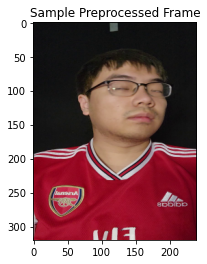

(2251, 320, 240, 3)


In [2]:
from utils import preprocess_raw_video

filepath = "dataset/1/1_0.mp4"

RGB = preprocess_raw_video(filepath,320,240)

In [3]:
RGB[5:1605].shape

(1600, 320, 240, 3)

In [1]:
from data_to_mat import mp4_to_mat
filepath = "dataset/1/1_0.mp4"
mp4_to_mat(filepath,1)

2252.0 75.03552222222223
2252 1280 720
frames (2252, 720, 1280, 3)
1800


ValueError: could not broadcast input array from shape (240,320,3) into shape (720,1280,3)

In [4]:
import scipy.io as sio

mat_path =  'mat_dataset/subject1/p1_1.mat'
data = sio.loadmat(mat_path)

img = np.array(data['video'][0])
print(img)

[[[0.07058824 0.09019608 0.08627451]
  [0.0754902  0.09509804 0.09117647]
  [0.07189543 0.09150327 0.0875817 ]
  ...
  [0.06895425 0.08856209 0.07287582]
  [0.075817   0.09542484 0.07973856]
  [0.07745098 0.09705883 0.08137255]]

 [[0.06797386 0.0875817  0.08366013]
  [0.07124183 0.09084968 0.08692811]
  [0.07254902 0.09215686 0.08039216]
  ...
  [0.06830066 0.0879085  0.07222223]
  [0.0751634  0.09477124 0.07908497]
  [0.06405229 0.08366013 0.06797386]]

 [[0.06372549 0.08333334 0.06764706]
  [0.07810458 0.09771242 0.08202615]
  [0.06764706 0.0872549  0.07352941]
  ...
  [0.06176471 0.08137255 0.06568628]
  [0.075817   0.09542484 0.07973856]
  [0.0754902  0.09509804 0.07941177]]

 ...

 [[0.71895427 0.07777778 0.24052288]
  [0.7029412  0.06176471 0.22189543]
  [0.6993464  0.05816993 0.21699347]
  ...
  [0.83758175 0.70816994 0.7022876 ]
  [0.8411765  0.71176475 0.7058824 ]
  [0.8411765  0.71176475 0.7058824 ]]

 [[0.7267974  0.07647059 0.24509804]
  [0.722549   0.07091504 0.24346405]


In [6]:
import cv2
import numpy as np
cv2.namedWindow("image")  
cv2.imshow('image',img)
cv2.waitKey()  
cv2.destroyAllWindows()  